<p><h1><center>Prediction of Stroke</center></h1></p>
<p><h2><center>Analyzing clinical data for drivers of stroke</center></h2></p>

<h2><a href="https://mpavlenk.github.io/Prediction-of-Stroke/Prediction_of_Stroke.html">Data file</a><h2>
<h3><strong>INDEX:</strong><br></h3>
<p>1: <a href="#Data-processing">Data processing</a><br>
2: <a href="#Descriptive-statistics">Descriptive statistics</a><br>
3: <a href="#Visualizations">Visualizations</a><br>
4: <a href="#Regression analysis">Regression analysis</a><br>
5: <a href="#Evaluation of the model">Evaluation of the model</a><br>                   

Importing libraries

In [5]:
library(plyr)
library(dplyr)
library(ggplot2)
library(DT)
library(psych)
library(purrr)
library(pscl)
library(ROCR)

Overview of data

In [6]:
train.data<-read.csv("train_2v.csv", header = TRUE)
head(train.data)

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
30669,Male,3,0,0,No,children,Rural,95.12,18.0,,0
30468,Male,58,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
16523,Female,8,0,0,No,Private,Urban,110.89,17.6,,0
56543,Female,70,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
46136,Male,14,0,0,No,Never_worked,Rural,161.28,19.1,,0
32257,Female,47,0,0,Yes,Private,Urban,210.95,50.1,,0


In [7]:
# We have 3 data types in the dataset: categorical, numeric, IDs.
# 12 variables and 43400 observations.
str(train.data)

'data.frame':	43400 obs. of  12 variables:
 $ id               : int  30669 30468 16523 56543 46136 32257 52800 41413 15266 28674 ...
 $ gender           : Factor w/ 3 levels "Female","Male",..: 2 2 1 1 2 1 1 1 1 1 ...
 $ age              : num  3 58 8 70 14 47 52 75 32 74 ...
 $ hypertension     : int  0 1 0 0 0 0 0 0 0 1 ...
 $ heart_disease    : int  0 0 0 0 0 0 0 1 0 0 ...
 $ ever_married     : Factor w/ 2 levels "No","Yes": 1 2 1 2 1 2 2 2 2 2 ...
 $ work_type        : Factor w/ 5 levels "children","Govt_job",..: 1 4 4 4 3 4 4 5 4 5 ...
 $ Residence_type   : Factor w/ 2 levels "Rural","Urban": 1 2 2 1 1 2 2 1 1 2 ...
 $ avg_glucose_level: num  95.1 88 110.9 69 161.3 ...
 $ bmi              : num  18 39.2 17.6 35.9 19.1 50.1 17.7 27 32.3 54.6 ...
 $ smoking_status   : Factor w/ 4 levels "","formerly smoked",..: 1 3 1 2 1 1 2 3 4 3 ...
 $ stroke           : int  0 0 0 0 0 0 0 0 0 0 ...


<h1><font color="red"><center id="Data-processing">Data processing<a class="anchor-link" href="#Data-processing">&#182;</a><center></font></h1>

a) Quantifying missing values

In [8]:
# BMI has 3.4% of missing values. 
sort(apply(train.data, 2, function(x){sum(is.na(x))/length(x)}*100), decreasing = TRUE)

bmi                id            gender               age 
         3.368664          0.000000          0.000000          0.000000 
     hypertension     heart_disease      ever_married         work_type 
         0.000000          0.000000          0.000000          0.000000 
   Residence_type avg_glucose_level    smoking_status            stroke 
         0.000000          0.000000          0.000000          0.000000

In [9]:
#Replacing NAs with mean values in bmi 
train.data$bmi<-ifelse(is.na(train.data$bmi), mean(train.data$bmi, na.rm = TRUE), train.data$bmi)

In [10]:
#Replacing blanks with "Unknown" for smoking_status
train.data$smoking_status[train.data$smoking_status==""]<-NA
train.data$smoking_status<-as.factor(ifelse(is.na(train.data$smoking_status), "Unknown", paste(train.data$smoking_status)))

b) eliminating useless attributes (unique values - IDs)

In [11]:
train.data<-subset(train.data, select=-c(id))

In [12]:
#removing "others" from gender 
train.data<-filter(train.data, gender!="Other")

c) converting categorical variables to dummy variables

In [13]:
train.data$male=ifelse(train.data$gender=="Male",1,0)
train.data$gender=NULL
train.data$married=ifelse(train.data$ever_married=="Yes",1,0)
train.data$ever_married=NULL
train.data$rural_res=ifelse(train.data$Residence_type=="Rural",1,0)
train.data$Residence_type=NULL

<h1><font color="red"><center id=Descriptive-statistics">Descriptive statistics<a class="anchor-link" href="#"Descriptive-statistics">&#182;</a><center></font></h1>

In [14]:
# This descriptive statistics demonstrates characteristics of each variable for both groups: stroke and non-stroke patients.
# From the statistical analysis, we notice that mean values for all variables besided rural_res are 
# significantly higher for stroke patients than non-stroke patients, therefore we can preliminarily conclude 
# that individuals who are older with hypertension and/or heart disease with higher level of glucose and bmi are in a
#  risk group for stroke. 
train.data %>% split(.$stroke) %>% map(describe)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
age,1,42606,41.74332911,22.3862265,43.00,41.9455495,26.68680,0.08,82.00,81.92,-0.086933019,-0.9935530,0.1084539843
hypertension,2,42606,0.09062104,0.2870728,0.00,0.0000000,0.00000,0.00,1.00,1.00,2.852024515,6.1341878,0.0013907744
heart_disease,3,42606,0.04424259,0.2056360,0.00,0.0000000,0.00000,0.00,1.00,1.00,4.432556783,17.6479738,0.0009962397
work_type*,4,42606,3.46512228,1.2935857,4.00,3.5813824,0.00000,1.00,5.00,4.00,-0.884896293,-0.5680437,0.0062670019
avg_glucose_level,5,42606,104.02555485,42.6122105,91.47,95.8772065,23.94399,55.00,291.05,236.05,1.700284299,2.3166207,0.2064422967
bmi,6,42606,28.58609211,7.6673450,28.00,28.0614135,6.81996,10.10,97.60,87.50,0.915753345,2.1515728,0.0371457919
smoking_status*,7,42606,2.59738065,1.0948393,2.00,2.6217215,1.48260,1.00,4.00,3.00,0.066447752,-1.3605695,0.0053041403
stroke,8,42606,0.00000000,0.0000000,0.00,0.0000000,0.00000,0.00,0.00,0.00,NaN,NaN,0.0000000000
male,9,42606,0.40773600,0.4914194,0.00,0.3846741,0.00000,0.00,1.00,1.00,0.375491223,-1.8590500,0.0023807671
married,10,42606,0.63911186,0.4802638,1.00,0.6738837,0.00000,0.00,1.00,1.00,-0.579300798,-1.6644496,0.0023267218


T-test

In [15]:
# The T-test shows the difference between mean values of stroke and non-stroke patients for all variables
lapply(train.data[,c('age','male' , 'hypertension' , 'heart_disease' ,'married', 
                     'rural_res' , 'avg_glucose_level' , 
                     'bmi' )], function(i) t.test(i ~ train.data$stroke))

$age

	Welch Two Sample t-test

data:  i by train.data$stroke
t = -58.237, df = 879.78, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -27.28984 -25.51040
sample estimates:
mean in group 0 mean in group 1 
       41.74333        68.14345 


$male

	Welch Two Sample t-test

data:  i by train.data$stroke
t = -2.33, df = 810.26, p-value = 0.02005
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07704575 -0.00658825
sample estimates:
mean in group 0 mean in group 1 
       0.407736        0.449553 


$hypertension

	Welch Two Sample t-test

data:  i by train.data$stroke
t = -10.526, df = 794.49, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1955405 -0.1340731
sample estimates:
mean in group 0 mean in group 1 
     0.09062104      0.25542784 


$heart_disease

	Welch Two Sample t-test

data:  i

<h1><font color="red"><center id="Visualizations">Visualizations<a class="anchor-link" href="#Visualizations">&#182;</a><center></font></h1>

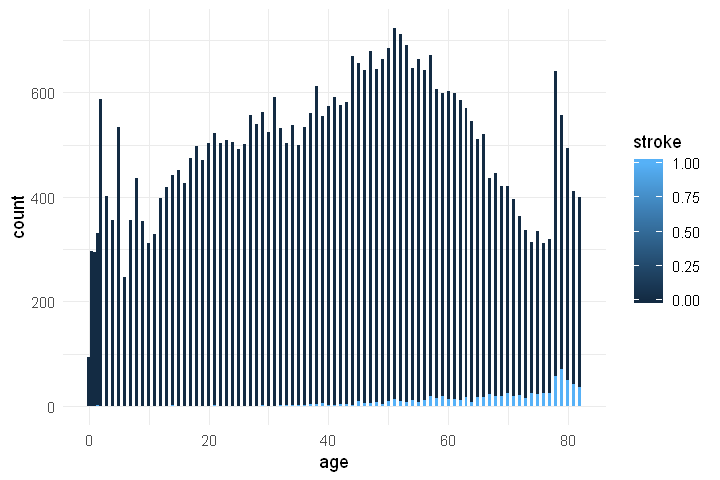

In [16]:
# Count of stroke and non-stroke patients by age. This illustration shows that peak of the stoke patients are
# in the age range 78-82. The stroke is not oversed in the young group patients 0-32 years old. The average age for a 
# stroke is about 68 years old.
options(repr.plot.width=6, repr.plot.height=4)
ggplot(train.data,aes(x=age,group=stroke,fill=stroke))+
  geom_histogram(position="identity",binwidth=0.5)+theme_minimal()

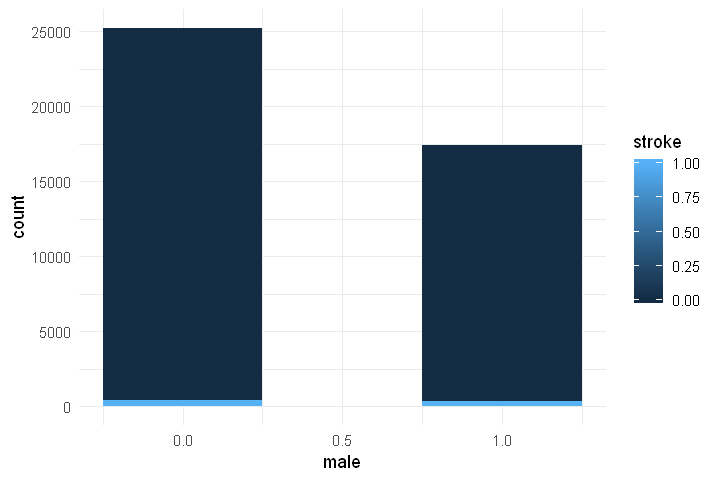

In [17]:
# This graph shows distribution of healthy and unhealthy patients by gender. 
ggplot(train.data,aes(x=male,group=stroke,fill=stroke))+
  geom_histogram(position="identity",binwidth=0.5)+theme_minimal()

In [46]:
# The next table quntifies it and we can see that distibution is not significantly different for males and females. 
m<-train.data%>%
  group_by(male, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%

print(as.data.frame(m))

# A tibble: 4 x 4
# Groups:   male [2]
   male stroke count percent
  <dbl> <fct>  <int>   <dbl>
1     0 0      25234   98.3 
2     0 1        431    1.68
3     1 0      17372   98.0 
4     1 1        352    1.99


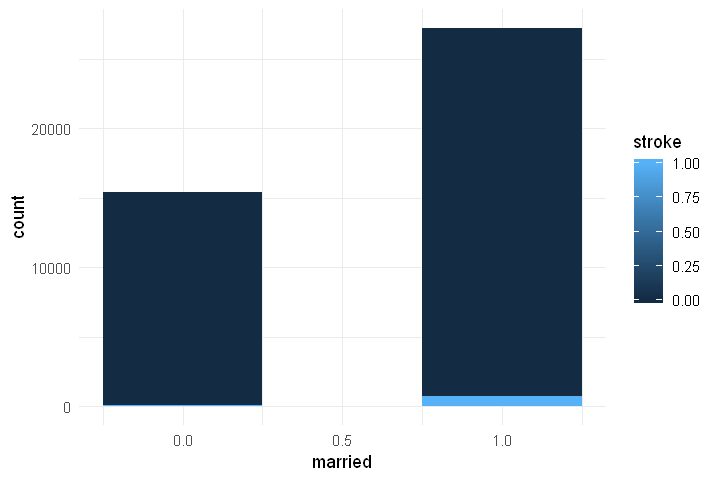

In [19]:
# The next plot illustrates that married people are more likely (by about 2%) to get a stroke than the ones 
# who are not married.
ggplot(train.data,aes(x=married,group=stroke,fill=stroke))+
  geom_histogram(position="identity",binwidth=0.5)+theme_minimal()

In [47]:
# The next table give it a more precise look. Single individuals have about 5 times less chance to get a stroke than
# married people.
n<-train.data%>%
  group_by(married, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%
print(as.data.frame(n))

# A tibble: 4 x 4
# Groups:   married [2]
  married stroke count percent
    <dbl> <fct>  <int>   <dbl>
1       0 0      15376   99.5 
2       0 1         80    0.52
3       1 0      27230   97.5 
4       1 1        703    2.52


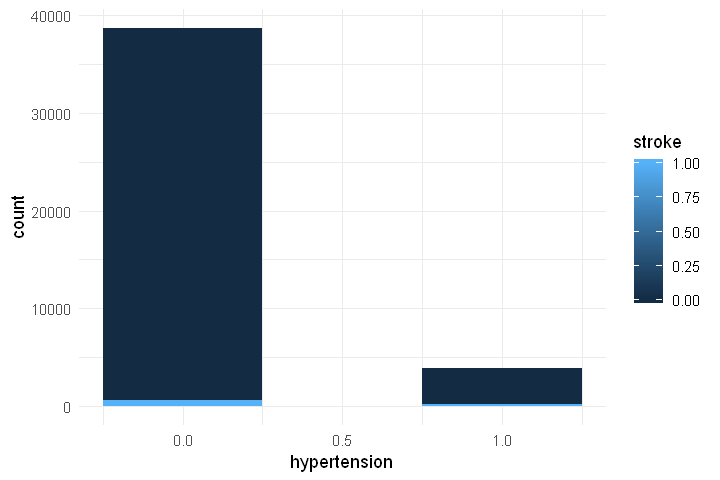

In [21]:
# Hipertension per stroke and non-stroke patients
ggplot(train.data,aes(x=hypertension,group=stroke,fill=stroke))+
  geom_histogram(position="identity",binwidth=0.5)+theme_minimal()

In [48]:
# 1.5% out of people without hypertension typically get a stroke, while about 5% out of patients with hypertension get 
# a stroke. # The latter indicates that people with hypertention have a higher risk to get a stroke than people who dont
# have hypertension.
k<-train.data%>%
  group_by(hypertension, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%
print(as.data.frame(k))

# A tibble: 4 x 4
# Groups:   hypertension [2]
  hypertension stroke count percent
         <int> <fct>  <int>   <dbl>
1            0 0      38745   98.5 
2            0 1        583    1.48
3            1 0       3861   95.1 
4            1 1        200    4.92


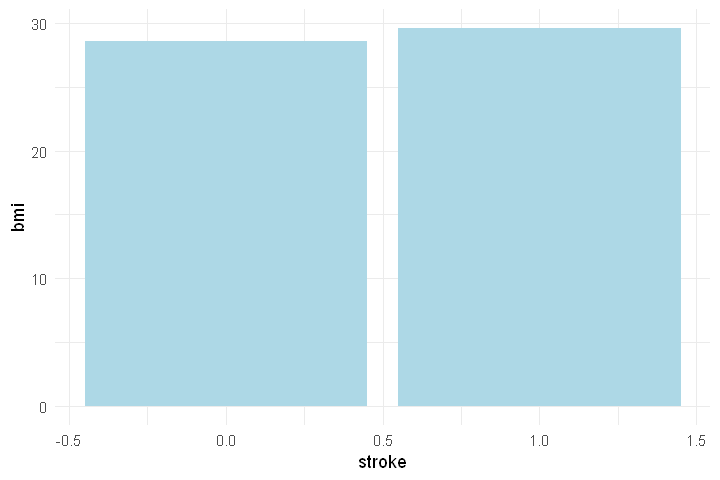

In [23]:
# People with high bmi have more chances to get a stroke.
bmi<-train.data %>%
  group_by(stroke)%>%
  summarise(bmi=mean(bmi))
ggplot(bmi,aes(x = stroke,y=bmi)) +
  geom_bar(stat="identity",position=position_identity(), fill="lightblue")+theme_minimal()

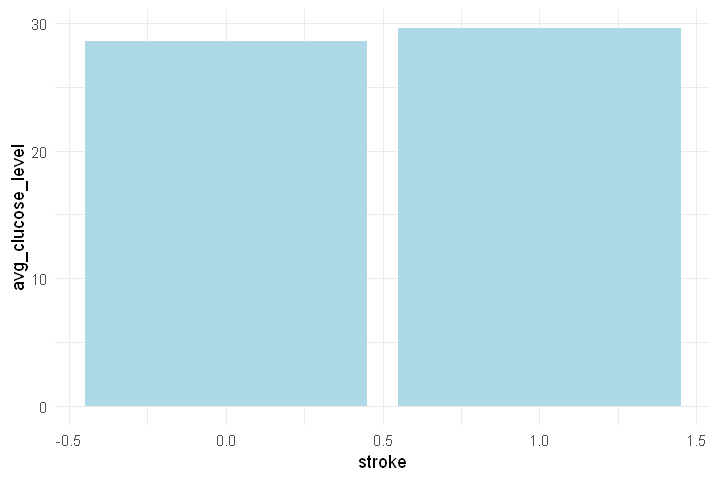

In [24]:
# The same refers to the glucose level. Stroke patients typically have a higher glucose level than healthy people.
avg_clucose_level<-train.data %>%
  group_by(stroke)%>%
  summarise(avg_clucose_level=mean(bmi))
ggplot(avg_clucose_level,aes(x = stroke,y=avg_clucose_level)) +
  geom_bar(stat="identity",position=position_identity(), fill="lightblue")+theme_minimal()

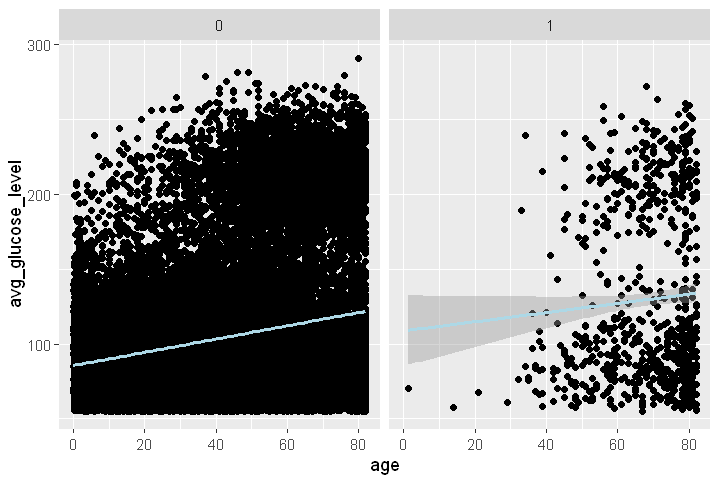

In [25]:
# Glucose level by age
ggplot(train.data, aes(x = age, y = avg_glucose_level)) + 
  geom_point() +
  facet_wrap(~ stroke)+
  geom_smooth(method = 'lm', color='lightblue')

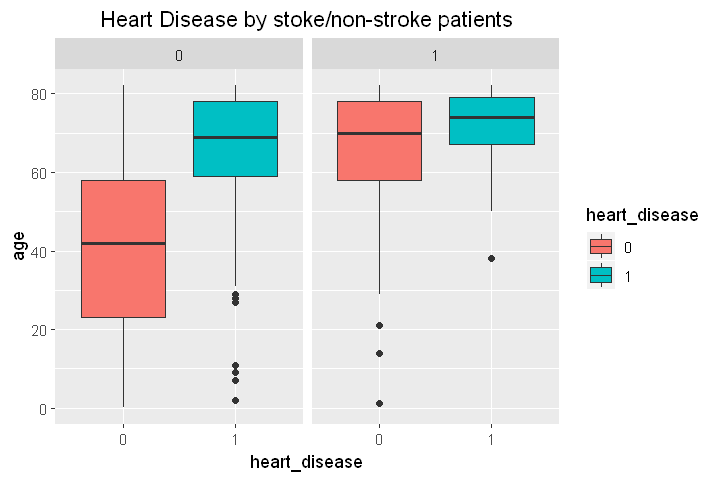

In [26]:
# This boxplot demonstrates correlation between stroke and heart_desease. People with a heart disease
# have higher chances to get a stroke.
ggplot(train.data, aes(as.factor(heart_disease), age, fill = as.factor(heart_disease)))+
  geom_boxplot()+
  labs(title = "Heart Disease by stoke/non-stroke patients",
    x = "heart_disease")+
  scale_fill_discrete("heart_disease")+
  facet_wrap(~ stroke)+
  theme(plot.title = element_text(hjust = .5))

In [49]:
# The next illustration shows the most interesting observations about the stroke. For example, people who never worked
# have zero chance to get a stroke. However, self-employed have the highest risk factor 3.7%. It might be 
# explained that they experience more stress, and more responsibilities.
l<-train.data%>%
  group_by(work_type, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%
print(as.data.frame(l))

# A tibble: 9 x 4
# Groups:   work_type [5]
  work_type     stroke count percent
  <fct>         <fct>  <int>   <dbl>
1 children      0       6152  100.0 
2 children      1          2    0.03
3 Govt_job      0       5349   98.4 
4 Govt_job      1         89    1.64
5 Never_worked  0        177  100   
6 Private       0      24386   98.2 
7 Private       1        441    1.78
8 Self-employed 0       6542   96.3 
9 Self-employed 1        251    3.69


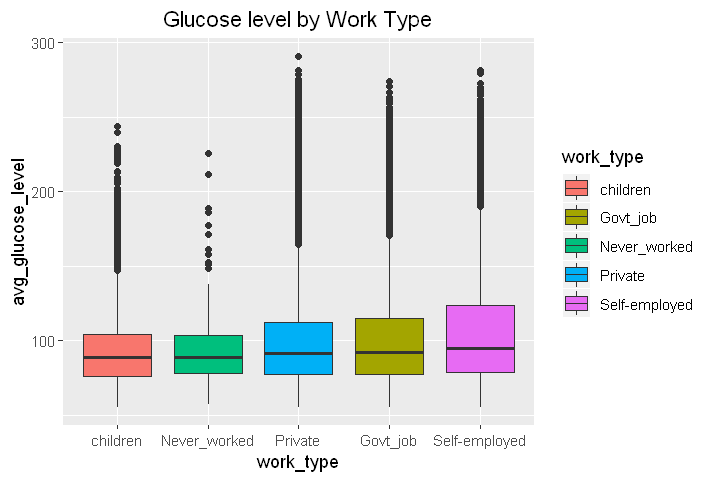

In [28]:
# Glucose level per jobe type. never_worked group has the lowest glucose lelvel, high stress work type like self-employed
# relatively has the highest glucose value. 
# The same interpretation can be applied to bmi.
ggplot(train.data, aes(reorder(work_type, avg_glucose_level), avg_glucose_level, fill = work_type))+
  geom_boxplot()+
  labs(    title = "Glucose level by Work Type",
    x = "work_type")+
  theme(plot.title = element_text(hjust = .5))

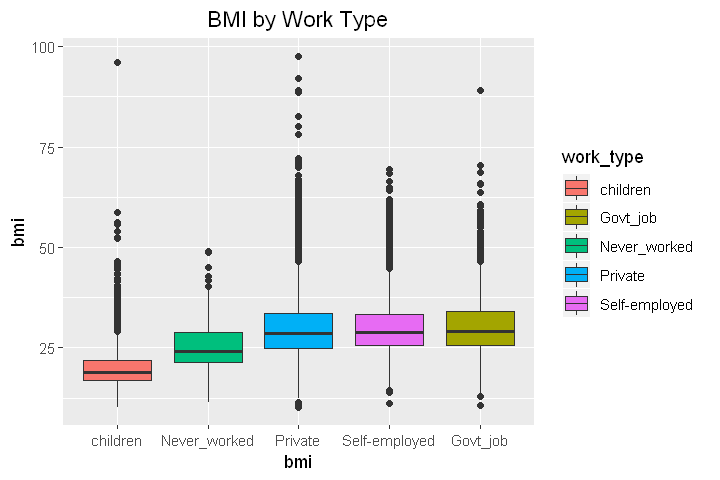

In [29]:
ggplot(train.data, aes(reorder(work_type, bmi), bmi, fill = work_type))+
  geom_boxplot()+
  labs(    title = "BMI by Work Type",
           x = "bmi")+
  theme(plot.title = element_text(hjust = .5))

In [50]:
# Chances of stroke are almost equally distributed among rural vs urban residents which means residence type 
# merely affects stroke probability.
o<-train.data%>%
  group_by(rural_res, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%
print(as.data.frame(o))

# A tibble: 4 x 4
# Groups:   rural_res [2]
  rural_res stroke count percent
      <dbl> <fct>  <int>   <dbl>
1         0 0      21352   98.2 
2         0 1        399    1.83
3         1 0      21254   98.2 
4         1 1        384    1.77


In [51]:
# The difference between people who formerly smoked and never smoked and got a stroke is around 25%. 
p<-train.data%>%
  group_by(smoking_status, stroke = as.factor(stroke))%>%
  summarise(count = n())%>%
  mutate(percent = round(count/sum(count)*100,2))%>%
print(as.data.frame(p))

# A tibble: 8 x 4
# Groups:   smoking_status [4]
  smoking_status  stroke count percent
  <fct>           <fct>  <int>   <dbl>
1 formerly smoked 0       7266   97.0 
2 formerly smoked 1        221    2.95
3 never smoked    0      15767   98.2 
4 never smoked    1        284    1.77
5 smokes          0       6428   98.0 
6 smokes          1        133    2.03
7 Unknown         0      13145   98.9 
8 Unknown         1        145    1.09


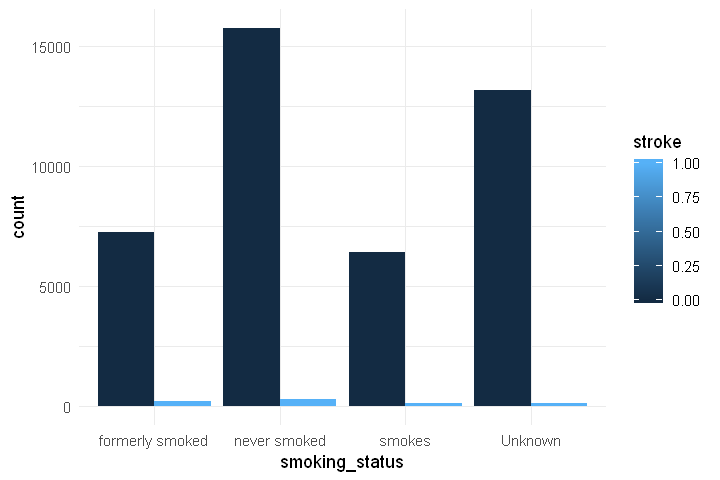

In [32]:
ggplot(train.data,aes(x=smoking_status,group=stroke,fill=stroke))+
  geom_bar(position="dodge")+theme_minimal()

<h1><font color="red"><center id="Regression analysis">Regression analysis<a class="anchor-link" href="#Reression analysis">&#182;</a><center></font></h1>

In [33]:
# Based on high p-values(>0.5), we identify insignificant variables like married.
summary(glm(stroke ~ age+married+male+hypertension+bmi+avg_glucose_level+
              heart_disease, data=train.data, family="binomial"))


Call:
glm(formula = stroke ~ age + married + male + hypertension + 
    bmi + avg_glucose_level + heart_disease, family = "binomial", 
    data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8220  -0.1955  -0.1043  -0.0525   4.0453  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -8.2721737  0.2845278 -29.073  < 2e-16 ***
age                0.0700328  0.0029060  24.099  < 2e-16 ***
married           -0.0641752  0.1239570  -0.518  0.60465    
male               0.0900964  0.0751554   1.199  0.23061    
hypertension       0.3137743  0.0873849   3.591  0.00033 ***
bmi               -0.0093171  0.0060877  -1.530  0.12590    
avg_glucose_level  0.0037533  0.0006566   5.716 1.09e-08 ***
heart_disease      0.6266817  0.0941966   6.653 2.87e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7839.0  on 43388  

In [34]:
# We will repeat the model excluding insignificant variables.
# AIC slightly reduced
model<-glm(stroke ~ age+hypertension+bmi+male+avg_glucose_level+
              heart_disease, data=train.data, family=binomial)
summary(model)


Call:
glm(formula = stroke ~ age + hypertension + bmi + male + avg_glucose_level + 
    heart_disease, family = binomial, data = train.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8230  -0.1960  -0.1045  -0.0516   4.0553  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -8.3078422  0.2772934 -29.960  < 2e-16 ***
age                0.0697791  0.0028751  24.270  < 2e-16 ***
hypertension       0.3135123  0.0873690   3.588 0.000333 ***
bmi               -0.0094598  0.0060860  -1.554 0.120098    
male               0.0893218  0.0751373   1.189 0.234526    
avg_glucose_level  0.0037496  0.0006565   5.712 1.12e-08 ***
heart_disease      0.6275293  0.0941765   6.663 2.68e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 7839  on 43388  degrees of freedom
Residual deviance: 6452  on 43382  degrees of freedom
AIC: 64

In [35]:
exp(coef(model))

(Intercept)               age      hypertension               bmi 
     0.0002465755      1.0722712872      1.3682223567      0.9905847610 
             male avg_glucose_level     heart_disease 
     1.0934324940      1.0037566732      1.8729772591

#### Interpreting results of algorithms

In [36]:
# The regression informs us that for every one unit increase in Age, 
# the odds of getting a stroke increases by a factor of 1.07.
# every one unit increase in hypertension, 
# the odds of getting a stroke increases by a factor of 1.37.
# every one unit increase in glucose level, 
# the odds of getting a stroke increases by a factor of 1.00.
# every one unit increase in heart disease, 
# the odds of getting a stroke increases by a factor of 1.87.

<h1><font color="red"><center id="Evaluation of the model">Evaluation of the model<a class="anchor-link" href="#Evaluation of the model">&#182;</a><center></font></h1>

In [37]:
# Pseudo R^2 to measure predictive power of the model
# McFadden value is close to 0.18 which indicates that it is a good model, however it has a room for improvement. 
pR2(model)

llh       llhNull            G2      McFadden          r2ML 
-3.225999e+03 -3.919503e+03  1.387008e+03  1.769367e-01  3.146128e-02 
         r2CU 
 1.903426e-01

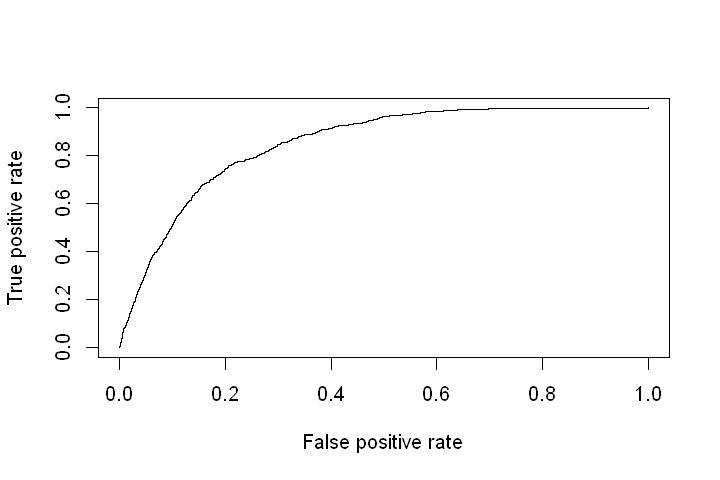

In [38]:
# Compute AUC for predicting stroke with the model
# ROC curve is pretty close to the upper left corner, which indicates the accuracy of the model. 
# Values above 0.80 indicate that the model does a good job in discriminating
# between the two categories which comprise our target variable.
prob <- predict(model, train.data, type="response")
pred <- prediction(prob, train.data$stroke)
perf <- performance(pred, measure = "tpr", x.measure = "fpr")
plot(perf)

Our analysis identified the factors which influence probability of getting a stroke. They are high glucose level,
older age, obeisity, high blood pressure, heart desease, high stress level (self-employed).